<a href="https://colab.research.google.com/github/Albmargar1/ClickbaitDetector/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <a name = 'Index'> </a> <font color='orange'> Índice </font>

* [Notas iniciales](#NotasIniciales)
* [Instalación del entorno](#setup) (Obligatorio ejecutar)
* [Parámetros por defecto](#parameters) (Obligatorio ejecutar)
* [Funciones principales](#Pipeline)
 * [Análisis descriptivo](#descriptive) (Obligatorio ejecutar)
 * [Fine-tuning de modelo pre-entrenado](#finetuning_function) (Obligatorio ejecutar)
 * [Evaluación del modelo](#eval_function) (Obligatorio ejecutar)
* [Análisis descriptivo de los datos](#preanalysis)
* [Modelos propuestos](#models)
* [Entrenamiento usando Fine-tuning](#Fine-tuning):
  * 'postText' (Texto del tweet)
    * [Búsqueda de hiperparámetros en BERT](#M1)
    * [Búsqueda de hiperparámetros en RoBERTa](#M2)
    * [Búsqueda de hiperparámetros en XLM-RoBERTa](#M3)
  * 'postText' (Texto del tweet) + 'targetKeywords' (Palabras claves del enlace)
    * [Búsqueda de hiperparámetros en BERT](#M4)
    * [Búsqueda de hiperparámetros en RoBERTa](#M5)
    * [Búsqueda de hiperparámetros en XLM-RoBERTa](#M6)
  * 'postText' (Texto del tweet) + 'targetParagraphs' (Texto del enlace)
    * [Búsqueda de hiperparámetros en Longformer](#M7)
* [Evaluación del dataset para cada modelo entrenado](#eval) 
  * [Comparación con estado del arte](#soa)
  * [Comparación predicciones con análisis descriptivo inicial](#postanalysis)
* [Análisis de errores](#errors)
* [Otras funciones](#Otros)
 * [Subir checkpoint a HuggingFace](#upload)
 * [Liberar cache GPU](#GPU)

# <a name="NotasIniciales"> </a> <font color='orange'> Notas iniciales </font>

* Cambiar métricas, aparecen uans de GLUE

<font color='lightgreen'> Comentarios </font>
* # NO EJECUTAR TODAS LAS CELDAS A LA VEZ
Llevará mucho tiempo y posiblemente la GPU se quede sin espacio. Las secciones de 'Instalación del entorno', 'Parámetros por defecto' y 'Funciones principales' **deben ejecutarse**. Truco: puedes ir a la sección [Análisis descriptivo de los datos](#preanalysis) y ejecutar todo lo anterior (CTRL + F8), y posteriormente acceder a la sección deseada.

* Este es el **archivo principal** donde se recogen todas las pruebas. Cada prueba llama a una función dada una configuración de parámetros específica. La mayoría de las funciones se encuentran definidas en la carpeta de 'utils'.

* El índice contiene enlaces a cada sección para una navegación más cómoda. 

<font color='lightgreen'> Referencias </font>

Quiero mencionar dos proyectos que hacen un trabajo muy parecido. Aunque obtengo ideas de ellos, considero que no hay plagio. Dichos trabajos servirán como referencia para comparar el modelo aquí desarrollado.
* [Click-BERT: Clickbait Detector with Bidirectional Encoder Representations
from Transformers](https://github.com/PeterQiu0516/Click-BERT)
* [BERT, XLNet or RoBERTa: The Best Transfer Learning Model to Detect
Clickbaits](https://www.researchgate.net/publication/356276903_BERT_XLNet_or_RoBERTa_The_Best_Transfer_Learning_Model_to_Detect_Clickbaits)


[Volver al índice](#Index)
<a name=setup></a>
# <font color='orange'> Instalación del entorno </font>
Clonar el proyecto, instalar e importar dependencias.

In [1]:
!git clone https://github.com/Albmargar1/ClickbaitDetector -q

In [2]:
!pip install -q transformers

     |████████████████████████████████| 4.0 MB 4.0 MB/s 
     |████████████████████████████████| 77 kB 5.4 MB/s 
     |████████████████████████████████| 895 kB 46.5 MB/s 
     |████████████████████████████████| 6.5 MB 34.9 MB/s 
     |████████████████████████████████| 596 kB 37.3 MB/s 


In [3]:
!pip install datasets -q folium==0.2.1 # Tengo que especificar la versión de folium o da error al instalar la librería de datasets de Hugging Face

     |████████████████████████████████| 325 kB 4.3 MB/s 
     |████████████████████████████████| 69 kB 7.6 MB/s 
     |████████████████████████████████| 1.1 MB 47.8 MB/s 
     |████████████████████████████████| 212 kB 37.9 MB/s 
     |████████████████████████████████| 136 kB 52.3 MB/s 
     |████████████████████████████████| 127 kB 51.5 MB/s 
     |████████████████████████████████| 144 kB 49.9 MB/s 
     |████████████████████████████████| 271 kB 50.7 MB/s 
     |████████████████████████████████| 94 kB 1.9 MB/s 


In [4]:
!pip install optuna -q

     |████████████████████████████████| 308 kB 4.4 MB/s 
     |████████████████████████████████| 210 kB 34.7 MB/s 
     |████████████████████████████████| 81 kB 6.2 MB/s 
     |████████████████████████████████| 78 kB 6.1 MB/s 
     |████████████████████████████████| 150 kB 48.3 MB/s 
     |████████████████████████████████| 49 kB 5.0 MB/s 
     |████████████████████████████████| 113 kB 49.0 MB/s 


In [66]:
import sys
sys.path.append('/content/ClickbaitDetector/')

import optuna
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification
import datasets
from datasets import load_metric
import torch
from torch.utils.data import DataLoader, SequentialSampler
import numpy as np
import pandas as pd

from utils import data_processing, descriptive_analysis
from utils.Objective import Objective
from utils.bcolors import bcolors

[Volver al índice](#Index)
<a name='parameters'> </a>
# <font color='orange'> Parámetros por defecto </font>
Por comodidad, los parámetros a ajustar se encuentran en la parte superior del cuaderno.

In [6]:
default_config = {}

# Directories
default_config['train_dir'] = '/content/ClickbaitDetector/data/webis_train.csv'
default_config['test_dir'] = '/content/ClickbaitDetector/data/webis_test.csv'

# Descriptive analysis
default_config['logger_transformers'] = 'error'

# Dataset
default_config['train_val_split'] = 0.15
default_config['clip'] = [0.5,0.5]
default_config['inputs'] = ['postText']

# Hyperparameter search
default_config['n_trials'] = 4
default_config['hp'] = {'learning_rate': [1e-5, 5e-5], # Uniform sampling between min-max
                        'epochs': [1,3], # Pick int between min-max
                        'batch_size_train': [16, 32]} # Pick one

# Checkpoint
default_config['checkpoint'] = 'bert-base-uncased'
default_config['model_name'] = default_config['checkpoint'] + '-clickbait'
default_config['finetuned_model_dir'] = './ClickbaitDetector/model/' + default_config['model_name'] 
default_config['cloud_dir'] = 'Stremie/'+ default_config['model_name'] + '-best'

[Volver al índice](#Index)
<a name='Pipeline'> </a>
# <font color='orange'> Funciones principales </font>

[Volver al índice](#Index)

<a name=descriptive></a>
<font color='lightgreen'> Análisis descriptivo </font>

In [7]:
def do_descriptive_analysis(data):
  descriptive_analysis.overall_info(data)
  descriptive_analysis.study_std(data)
  descriptive_analysis.probability_clickbait_per_tweet_count_words(data)
  descriptive_analysis.given_word_check_probability_clickbait(data)

[Volver al índice](#Index)
<a name= finetuning_function> </a>

<font color='lightgreen'> Fine-tuning de modelo pre-entrenado </font>

In [8]:
def training(data_dir, p):
  data = data_processing.process_file(data_dir, p['inputs'])

  tokenizer = AutoTokenizer.from_pretrained(p['checkpoint'])
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  data_dic_train = data_processing.to_Dataset(data,
                                              clip=p['clip'],
                                              train_data=True, 
                                              train_val_split = p['train_val_split'])

  tokenized_dataset = data_processing.tokenize_dataset(data_dic_train, 
                                                      tokenizer)
    
  n_clickbaits_train = data_dic_train['train']['labels'].count(1)
  n_noclickbaits_train = data_dic_train['train']['labels'].count(0)
  prop_clickbait =  n_clickbaits_train / n_noclickbaits_train
    
  objective = Objective(p, tokenizer, data_collator, tokenized_dataset, prop_clickbait)
  study = optuna.create_study(study_name=p['model_name'], direction='maximize') 
  study.optimize(objective, n_trials=p['n_trials'], callbacks=[objective.callback]) 
  objective.best_model.save_pretrained(p['finetuned_model_dir'])
  tokenizer.save_pretrained(p['finetuned_model_dir'])

[Volver al índice](#Index)
<a name= eval_function> </a>

<font color='lightgreen'> Evaluación del modelo </font>

In [27]:
def model_performance(p, checkpoint):
  tokenizer = AutoTokenizer.from_pretrained(checkpoint)
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  # model
  model = AutoModelForSequenceClassification.from_pretrained(
          checkpoint, num_labels=2, return_dict=True)
  device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
  model.to(device)
  model.eval()

  # metric
  metric = datasets.load_metric("glue", "mrpc")

  # load data
  data = data_processing.process_file(p['test_dir'], p['inputs'])
  data_dic = data_processing.to_Dataset(data)

  # tokenize
  tokenized_raw = data_processing.tokenize_dataset(data_dic, tokenizer)

  tokenized = datasets.Dataset.from_dict({
        'input_ids': tokenized_raw['test']['input_ids'],
        'attention_mask': tokenized_raw['test']['attention_mask'],
        'labels': tokenized_raw['test']['labels']})
  

  if 'token_type_ids' in tokenized_raw['test'].features:
    tokenized.add_column('token_type_ids', tokenized_raw['test']['token_type_ids'])

  tokenized.set_format("torch")

  # create loader    
  loader = DataLoader(tokenized, batch_size=32, collate_fn=data_collator)

  # compute overall accuracy and F1-score
  predictions = []
  for batch in loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)

    logits = outputs.logits
    predictions_batch = torch.argmax(logits, dim=-1)
    predictions = predictions + predictions_batch.tolist()
    metric.add_batch(predictions=predictions_batch, references=batch["labels"])

  results = metric.compute()
  print('Resultados del modelo cuyo checkpoint es:', checkpoint)
  print(results)

  return predictions, results

[Volver al índice](#Index)
<a name='preanalysis'></a>
# <font color='orange'> Análisis descriptivo </font>
Se realiza un análisis descriptivo básico, que incluye: 

*   Variabilidad de los anotadores
*   Probabilidad de clickbait en función del número de palabras por tweet
*   Probabilidad de que la palabra pertenezca a un clickbait


 

Tweets legítimos: 14777 
Tweets clickbait: 4761 
Tweets mal etiquetados: 0 
Proporción tweets clickbait: 0.24367898454294196 





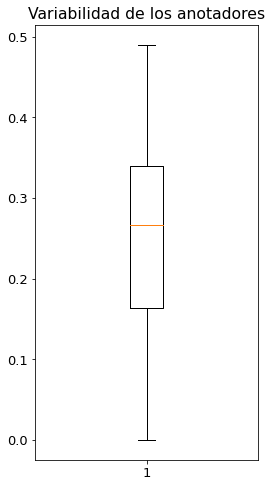

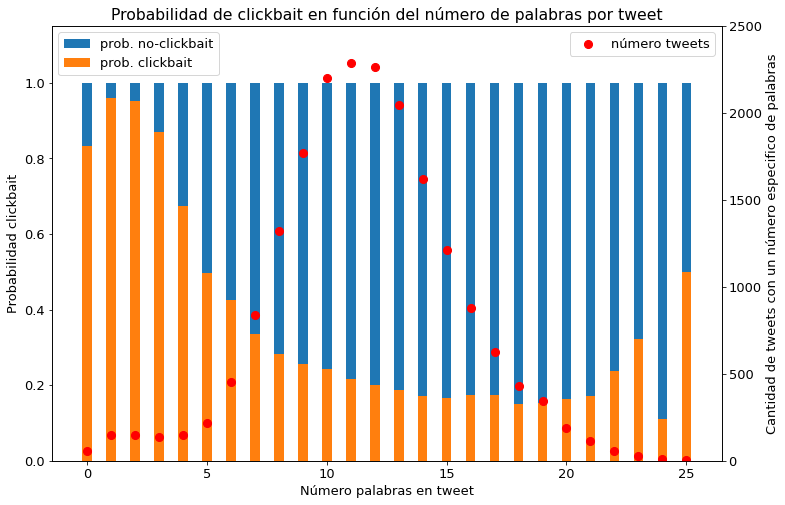

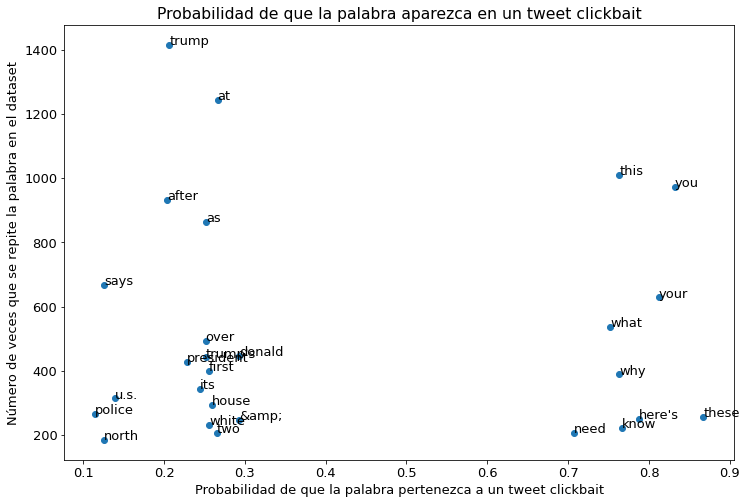

In [ ]:
data = data_processing.process_file(default_config['train_dir'], ['postText'])
do_descriptive_analysis(data)

<font color='lightgreen'> Descripción de los datos </font>

<font color='lightgreen'> Variabilidad de los anotadores </font>

Resulta interesante observar la variación de las puntuaciones del conjunto de anotadores para cada tweet. Esto puede representarse como un diagrama de cajas de la desviación típica de las puntuaciones.

A la vista de los datos, los anotadores no tienen un consenso muy definido entre sus valoraciones, lo cual podría resultar en confusiones a la hora de entrenar la red neuronal. 

Dado que los mayores valores de desviación típica implica que la correspondiente media está relativamente centrada (uno de los dos casos de mayor desviación típica sería el conjunto de puntuaciones [1, 1, 1, 0, 0], con media = 0.6 y desviación típica ~0.49), resulta relativamente seguro eliminar aquellos datos cuya media de las puntuaciones se encuentre cercana a 0.5.

Esto además nos permite descartar tweets con conjuntos de puntuaciones no polarizados, por ejemplo [0.66, 0.66, 0.66, 0.33, 0.33]. Aunque dicho tweet se considere clickbait, el conjunto de los anotadores no tiene certeza de ello, y puede provocar errores de clasificación durante el entrenamiento.

La cantidad de datos a descartar se tomará como un hiperparámetro. Esto puede perjudicar en que hay un menor número de datos que entrenar, por lo que no resulta obvio que vaya a mejorar el modelo. Por lo tanto, la cantidad de datos a descartar se tomará como un hiperparámetro.

*Nota: Esta idea proviene de este proyecto: [Click-BERT: Clickbait Detector with Bidirectional Encoder Representations
from Transformers](https://github.com/PeterQiu0516/Click-BERT/blob/main/Final-Report/EECS498NLP_Project_Final_Report.pdf)*, donde aseguran que mejoran las predicciones.



<font color='lightgreen'> Probabilidad de clickbait en función del número de palabras por tweet </font>

A la vista de la gráfica, podemos observar que la mayoría de tweets con un número de palabras muy bajo suele ser clickbait, y dicha probabilidad tiende a reducirse generalizadamente conforme aumenta el número de palabras. 

<font color='lightgreen'> Probabilidad de que la palabra aparezca en un clickbait </font>

Estos resultados no resultan muy reveladores, pero dan pequeñas pistas de qué se puede considerar legítimo y qué puede considerarse clickbait.

Por ejemplo, entre las palabras que más aparecen en los tweets que son clickbaits aparecen apelativos al lector 'you'/'your', preguntas 'what'/'why' y adjetivos demostrativos 'this'/'these'. 

En el caso de tweets legítimos, parece que tiende a poseer palabras menos ambiguas, tales como 'u.s.'/'police'/'trump'/'president'.

Igualmente hay clasificaciones extrañas. Por ejemplo, 'says' se ha catalogado como una palabra que se usa mucho en tweets legítimos, cuando es una palabra que puede recordar a un clickbait.

[Volver al índice](#Index)
<a name=Fine-tuning></a>
# <font color='orange'> Entrenamiento usando Fine-tuning </font>

[Volver al índice](#Index)

<a name='M1'></a>
<font color='lightgreen'> 'postText' (Texto del tweet) -- Búsqueda de hiperparámetros en BERT </font>

In [ ]:
config_M1 = default_config
config_M1['checkpoint'] = 'bert-base-uncased'
config_M1['model_name'] = default_config['checkpoint'] + '-clickbait'
config_M1['finetuned_model_dir'] = './ClickbaitDetector/model/' + default_config['model_name'] 
config_M1['inputs'] = ['postText']

training(config_M1['train_dir'],config_M1)

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

[I 2022-04-06 12:38:10,541] A new study created in memory with name: bert-base-uncased-clickbait


 
Prueba 0 de 4 
Hiperparámetros para bert-base-uncased : 
learning_rate: 4.8763889962463215e-05 
epochs: 1 
batch_size_train: 16 


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.423200,0.378992,0.842375,0.721351


[I 2022-04-06 12:40:44,568] Trial 0 finished with value: 0.721351025331725 and parameters: {'learning_rate': 4.8763889962463215e-05, 'epochs': 1, 'batch_size_train': 16}. Best is trial 0 with value: 0.721351025331725.


 
 F1-score en test 0 = 0.721351025331725 
 Accuracy en test 0 = 0.842374616171955 
 
 
Prueba 1 de 4 
Hiperparámetros para bert-base-uncased : 
learning_rate: 3.881788274425803e-05 
epochs: 2 
batch_size_train: 16 


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.431700,0.400649,0.827021,0.703335
2,0.303900,0.463157,0.853292,0.718586


[I 2022-04-06 12:45:33,935] Trial 1 finished with value: 0.7185863874345549 and parameters: {'learning_rate': 3.881788274425803e-05, 'epochs': 2, 'batch_size_train': 16}. Best is trial 0 with value: 0.721351025331725.


 
 F1-score en test 1 = 0.7185863874345549 
 Accuracy en test 1 = 0.8532923916751962 
 
 
Prueba 2 de 4 
Hiperparámetros para bert-base-uncased : 
learning_rate: 3.4185493262948674e-05 
epochs: 2 
batch_size_train: 16 


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.427200,0.401732,0.833845,0.712684
2,0.298200,0.453267,0.852269,0.722614


[I 2022-04-06 12:50:19,617] Trial 2 finished with value: 0.7226137091607943 and parameters: {'learning_rate': 3.4185493262948674e-05, 'epochs': 2, 'batch_size_train': 16}. Best is trial 2 with value: 0.7226137091607943.


 
 F1-score en test 2 = 0.7226137091607943 
 Accuracy en test 2 = 0.8522688502217673 
 
 
Prueba 3 de 4 
Hiperparámetros para bert-base-uncased : 
learning_rate: 3.968800943614797e-05 
epochs: 3 
batch_size_train: 16 


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.434400,0.416788,0.834869,0.710526
2,0.316600,0.540153,0.852610,0.706522
3,0.196700,0.760798,0.848857,0.691289


[I 2022-04-06 12:57:30,195] Trial 3 finished with value: 0.6912891986062718 and parameters: {'learning_rate': 3.968800943614797e-05, 'epochs': 3, 'batch_size_train': 16}. Best is trial 2 with value: 0.7226137091607943.


 
 F1-score en test 3 = 0.6912891986062718 
 Accuracy en test 3 = 0.8488570453770045 
 


[Volver al índice](#Index)

<a name='M2'></a>
<font color='lightgreen'> 'postText' (Texto del tweet) -- Búsqueda de hiperparámetros en RoBERTa </font>

In [ ]:
config_M2 = default_config
config_M2['checkpoint'] = 'roberta-base'
config_M2['model_name'] = default_config['checkpoint'] + '-clickbait'
config_M2['finetuned_model_dir'] = './ClickbaitDetector/model/' + default_config['model_name'] 
config_M2['inputs'] = ['postText']

training(config_M2['train_dir'],config_M2)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

[I 2022-04-06 13:09:09,068] A new study created in memory with name: roberta-base-clickbait


 
Prueba 0 de 4 
Hiperparámetros para roberta-base : 
learning_rate: 4.0963638314565254e-05 
epochs: 2 
batch_size_train: 32 


Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.448300,0.451870,0.852610,0.709677
2,0.327600,0.436942,0.843057,0.702842


[I 2022-04-06 13:13:50,017] Trial 0 finished with value: 0.7028423772609819 and parameters: {'learning_rate': 4.0963638314565254e-05, 'epochs': 2, 'batch_size_train': 32}. Best is trial 0 with value: 0.7028423772609819.


 
 F1-score en test 0 = 0.7028423772609819 
 Accuracy en test 0 = 0.8430569771409075 
 
 
Prueba 1 de 4 
Hiperparámetros para roberta-base : 
learning_rate: 4.09141014526183e-05 
epochs: 1 
batch_size_train: 32 


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.436300,0.390105,0.832139,0.699634


[I 2022-04-06 13:16:11,549] Trial 1 finished with value: 0.6996336996336997 and parameters: {'learning_rate': 4.09141014526183e-05, 'epochs': 1, 'batch_size_train': 32}. Best is trial 0 with value: 0.7028423772609819.


 
 F1-score en test 1 = 0.6996336996336997 
 Accuracy en test 1 = 0.8321392016376663 
 
 
Prueba 2 de 4 
Hiperparámetros para roberta-base : 
learning_rate: 2.14168003397444e-05 
epochs: 3 
batch_size_train: 32 


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.447200,0.436278,0.851928,0.708725
2,0.343100,0.486890,0.851928,0.712583
3,0.272000,0.498258,0.847834,0.703063


[I 2022-04-06 13:22:58,287] Trial 2 finished with value: 0.7030625832223701 and parameters: {'learning_rate': 2.14168003397444e-05, 'epochs': 3, 'batch_size_train': 32}. Best is trial 2 with value: 0.7030625832223701.


 
 F1-score en test 2 = 0.7030625832223701 
 Accuracy en test 2 = 0.8478335039235756 
 
 
Prueba 3 de 4 
Hiperparámetros para roberta-base : 
learning_rate: 3.110030998183404e-05 
epochs: 1 
batch_size_train: 16 


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.410200,0.400335,0.847492,0.715105


[I 2022-04-06 13:25:41,399] Trial 3 finished with value: 0.7151051625239006 and parameters: {'learning_rate': 3.110030998183404e-05, 'epochs': 1, 'batch_size_train': 16}. Best is trial 3 with value: 0.7151051625239006.


 
 F1-score en test 3 = 0.7151051625239006 
 Accuracy en test 3 = 0.8474923234390993 
 


[Volver al índice](#Index)

<a name='M3'></a>
<font color='lightgreen'> 'postText' (Texto del tweet) -- Búsqueda de hiperparámetros en XLM-RoBERTa </font>

In [ ]:
config_M3 = default_config
config_M3['checkpoint'] = 'xlm-roberta-base'
config_M3['model_name'] = default_config['checkpoint'] + '-clickbait'
config_M3['finetuned_model_dir'] = './ClickbaitDetector/model/' + default_config['model_name'] 
config_M3['inputs'] = ['postText']
config_M3['n_trials'] = 1

default_config['hp'] = {'learning_rate': [1e-5, 5e-5], 
                        'epochs': [2,4], 
                        'batch_size_train': [16, 32]} 

training(config_M3['train_dir'],config_M3)

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

[I 2022-04-06 19:28:05,865] A new study created in memory with name: xlm-roberta-base-clickbait


 
Prueba 1 de 1 
Hiperparámetros para xlm-roberta-base 
learning_rate: 2.368107665238697e-05 
epochs: 3 
batch_size_train: 32 


Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.464000,0.424016,0.798704,0.662085
2,0.374700,0.460488,0.854657,0.690856
3,0.314900,0.456768,0.833845,0.681074


[I 2022-04-06 19:44:30,618] Trial 0 finished with value: 0.6810740013097576 and parameters: {'learning_rate': 2.368107665238697e-05, 'epochs': 3, 'batch_size_train': 32}. Best is trial 0 with value: 0.6810740013097576.


 
 F1-score para datos de validación en test 1 = 0.6810740013097576 
 Accuracy para datos de validación en test 1 = 0.8338451040600477 
 


[Volver al índice](#Index)

<a name='M4'></a>
<font color='lightgreen'> 'postText' (Texto del tweet) + 'targetKeywords' (Palabras claves del enlace) -- Búsqueda de hiperparámetros en BERT </font>

Recomiendo volver a empezar una sesión nueva. Ocupa mucho espacio en GPU.

In [ ]:
config_M4 = default_config
config_M4['checkpoint'] = 'bert-base-uncased'
config_M4['n_trials'] = 1
config_M4['model_name'] = default_config['checkpoint'] + '-clickbait-keywords'
config_M4['finetuned_model_dir'] = './ClickbaitDetector/model/' + default_config['model_name'] 
config_M4['inputs'] = ['postText', 'targetKeywords']
default_config['hp'] = {'learning_rate': [3e-5, 3e-5], 
                        'epochs': [2,2], 
                        'batch_size_train': [8]} 

training(config_M4['train_dir'],config_M4)

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

[I 2022-04-06 15:59:01,868] A new study created in memory with name: bert-base-uncased-clickbait-keywords-


 
Prueba 1 de 1 
Hiperparámetros para bert-base-uncased 
learning_rate: 3e-05 
epochs: 2 
batch_size_train: 8 


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.441600,0.460537,0.847151,0.697297
2,0.341400,0.664456,0.849539,0.693963


[I 2022-04-06 16:20:46,496] Trial 0 finished with value: 0.6939625260235947 and parameters: {'learning_rate': 3e-05, 'epochs': 2, 'batch_size_train': 8}. Best is trial 0 with value: 0.6939625260235947.


 
 F1-score para datos de validación en test 1 = 0.6939625260235947 
 Accuracy para datos de validación en test 1 = 0.849539406345957 
 


[Volver al índice](#Index)

<a name='M5'></a>
<font color='lightgreen'> 'postText' (Texto del tweet) + 'targetKeywords' (Palabras claves del enlace) -- Búsqueda de hiperparámetros en RoBERTa </font>

In [ ]:
config_M5 = default_config
config_M5['checkpoint'] = 'roberta-base'
config_M5['n_trials'] = 1
config_M5['model_name'] = default_config['checkpoint'] + '-clickbait-keywords'
config_M5['finetuned_model_dir'] = './ClickbaitDetector/model/' + default_config['model_name'] 
config_M5['inputs'] = ['postText', 'targetKeywords']
default_config['hp'] = {'learning_rate': [3e-5, 3e-5], 
                        'epochs': [2,2], 
                        'batch_size_train': [8]} 

training(config_M5['train_dir'],config_M5)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

[I 2022-04-06 16:33:28,171] A new study created in memory with name: roberta-base-clickbait-keywords


 
Prueba 1 de 1 
Hiperparámetros para roberta-base 
learning_rate: 3e-05 
epochs: 2 
batch_size_train: 8 


Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.523500,0.667688,0.849198,0.673560
2,0.441800,0.558655,0.858751,0.685888


[I 2022-04-06 16:57:22,710] Trial 0 finished with value: 0.6858877086494689 and parameters: {'learning_rate': 3e-05, 'epochs': 2, 'batch_size_train': 8}. Best is trial 0 with value: 0.6858877086494689.


 
 F1-score para datos de validación en test 1 = 0.6858877086494689 
 Accuracy para datos de validación en test 1 = 0.8587512794268168 
 


[Volver al índice](#Index)

<a name='M6'></a>
<font color='lightgreen'> 'postText' (Texto del tweet) + 'targetKeywords' (Palabras claves del enlace) -- Búsqueda de hiperparámetros en XLM-RoBERTa </font>

In [ ]:
config_M6 = default_config
config_M6['checkpoint'] = 'xlm-roberta-base'
config_M6['n_trials'] = 1
config_M6['model_name'] = default_config['checkpoint'] + '-clickbait-keywords'
config_M6['finetuned_model_dir'] = './ClickbaitDetector/model/' + default_config['model_name'] 
config_M6['inputs'] = ['postText', 'targetKeywords']
default_config['hp'] = {'learning_rate': [3e-5, 3e-5], 
                        'epochs': [2,2], 
                        'batch_size_train': [8]} 

training(config_M6['train_dir'],config_M6)

[Volver al índice](#Index)

<a name='M7'></a>
<font color='lightgreen'> 'postText' (Texto del tweet) + 'targetParagraph' (Palabras claves del enlace) -- Búsqueda de hiperparámetros en Longformer </font>

In [ ]:
config_M7 = default_config
config_M7['checkpoint'] = 'allenai/longformer-base-4096'
config_M7['n_trials'] = 1
config_M7['model_name'] = default_config['checkpoint'] + '-clickbait-keywords-'
config_M7['finetuned_model_dir'] = './ClickbaitDetector/model/' + default_config['model_name'] 
config_M7['inputs'] = ['postText', 'targetKeywords']
default_config['hp'] = {'learning_rate': [3e-5, 3e-5], 
                        'epochs': [2,2], 
                        'batch_size_train': [8]} 

training(config_M7['train_dir'],config_M7)

[Volver al índice](#Index)
<a name=eval></a>
# <font color='orange'> Evaluación del dataset para cada modelo entrenado </font>

Puedes usar cualquier checkpoint recién entrenado cambiando el argumento `checkpoint='checkpoint_dir'`, sustituyendo por el número del modelo que viene indicado en las celdas.

In [75]:
results = []

checkpoint_1 = 'bert-base-uncased-clickbait'
predictions_1, metrics_1 = model_performance(default_config, checkpoint=str('Stremie/'+checkpoint_1))
results.append({'predictions': predictions_1, 'metrics': metrics_1, 'checkpoint': checkpoint_1})

checkpoint_2 = 'roberta-base-cased-clickbait'
predictions_2, metrics_2 = model_performance(default_config, checkpoint=str('Stremie/'+checkpoint_2))
results.append({'predictions': predictions_2, 'metrics': metrics_2, 'checkpoint': checkpoint_2})

checkpoint_3 = 'xlm-roberta-base-cased-clickbait'
predictions_3, metrics_3 = model_performance(default_config, checkpoint=str('Stremie/'+checkpoint_3))
results.append({'predictions': predictions_3, 'metrics': metrics_3, 'checkpoint': checkpoint_3})

checkpoint_4 = 'bert-base-uncased-clickbait-keywords'
predictions_4, metrics_4 = model_performance(default_config, checkpoint=str('Stremie/'+checkpoint_4))
results.append({'predictions': predictions_4, 'metrics': metrics_4, 'checkpoint': checkpoint_4})

checkpoint_5 = 'roberta-base-cased-clickbait-keywords'
predictions_5, metrics_5 = model_performance(default_config, checkpoint=str('Stremie/'+checkpoint_5))
results.append({'predictions': predictions_5, 'metrics': metrics_5, 'checkpoint': checkpoint_5})

checkpoint_6 = 'xlm-roberta-base-cased-clickbait-keywords'
predictions_6, metrics_6 = model_performance(default_config, checkpoint=str('Stremie/'+checkpoint_6))
results.append({'predictions': predictions_6, 'metrics': metrics_6, 'checkpoint': checkpoint_6})

  0%|          | 0/19 [00:00<?, ?ba/s]

Resultados del modelo cuyo checkpoint es: Stremie/bert-base-uncased-clickbait
{'accuracy': 0.8593708836081986, 'f1': 0.7301041561330771}


  0%|          | 0/19 [00:00<?, ?ba/s]

Resultados del modelo cuyo checkpoint es: Stremie/roberta-base-cased-clickbait
{'accuracy': 0.8556299067390274, 'f1': 0.7329955174429936}


  0%|          | 0/19 [00:00<?, ?ba/s]

Resultados del modelo cuyo checkpoint es: Stremie/xlm-roberta-base-cased-clickbait
{'accuracy': 0.8556825965540861, 'f1': 0.7302806499261448}


  0%|          | 0/19 [00:00<?, ?ba/s]

Resultados del modelo cuyo checkpoint es: Stremie/bert-base-uncased-clickbait-keywords
{'accuracy': 0.8660098003056009, 'f1': 0.7121023434846598}


  0%|          | 0/19 [00:00<?, ?ba/s]

Resultados del modelo cuyo checkpoint es: Stremie/roberta-base-cased-clickbait-keywords
{'accuracy': 0.8699615364350071, 'f1': 0.7235663082437276}


  0%|          | 0/19 [00:00<?, ?ba/s]

Resultados del modelo cuyo checkpoint es: Stremie/xlm-roberta-base-cased-clickbait-keywords
{'accuracy': 0.8626903419568998, 'f1': 0.7230017006802721}


Los resultados se muestran en la siguiente tabla: 

In [91]:
labels = [model['checkpoint'] for model in results]
metrics = [[model['metrics']['f1'], model['metrics']['accuracy']] for model in results]
columns = ['F1', 'accuracy']
df = pd.DataFrame(metrics, index=labels, columns=columns)
df

,F1,accuracy
bert-base-uncased-clickbait,0.730104,0.859371
roberta-base-cased-clickbait,0.732996,0.855630
xlm-roberta-base-cased-clickbait,0.730281,0.855683
bert-base-uncased-clickbait-keywords,0.712102,0.866010
roberta-base-cased-clickbait-keywords,0.723566,0.869962
xlm-roberta-base-cased-clickbait-keywords,0.723002,0.862690


Los modelos poseen unas métricas muy parecidas. Vamos a comprobar si los modelos hacen las mismas predicciones a un conjunto de datos, o si por el contrario tienen métricas parecidas pero variando qué datos son clickbaits y cuáles no:

In [92]:
predictions = [model['predictions'] for model in results]

model_size = len(predictions)
pred_size = len(predictions[0])

overlapping_predictions = np.zeros((model_size, model_size))
for i in range(model_size):
  for j in range(i,model_size):
    coincidences = [1 if predictions[i][k] == predictions[j][k] else 0 for k in range(pred_size)]
    overlapping_predictions[i,j] = sum(coincidences) / pred_size 
    overlapping_predictions[j,i] = overlapping_predictions[i,j]

labels = [model['checkpoint'] for model in results]

df = pd.DataFrame(overlapping_predictions, index=labels, columns=labels)
df

,bert-base-uncased-clickbait,roberta-base-cased-clickbait,xlm-roberta-base-cased-clickbait,bert-base-uncased-clickbait-keywords,roberta-base-cased-clickbait-keywords,xlm-roberta-base-cased-clickbait-keywords
bert-base-uncased-clickbait,1.000000,0.931240,0.925602,0.927393,0.921123,0.920596
roberta-base-cased-clickbait,0.931240,1.000000,0.934085,0.905000,0.919279,0.923494
xlm-roberta-base-cased-clickbait,0.925602,0.934085,1.000000,0.906212,0.909005,0.920491
bert-base-uncased-clickbait-keywords,0.927393,0.905000,0.906212,1.000000,0.933769,0.916908
roberta-base-cased-clickbait-keywords,0.921123,0.919279,0.909005,0.933769,1.000000,0.933505
xlm-roberta-base-cased-clickbait-keywords,0.920596,0.923494,0.920491,0.916908,0.933505,1.000000


Todos los modelos poseen un conjunto de predicciones similares entorno al 91% y 93%. Esto significa que las predicciones son muy parecidas (dado que los valores de precisión y F1 son altos), pero existen diferencias entre las predicciones de todos ellos.

[Volver al índice](#Index)

<a name=soa></a>
<font color='lightgreen'> Comparación con estado del arte </font>

[Volver al índice](#Index)

<a name=postanalysis></a>
<font color='lightgreen'> Comparación predicciones con análisis descriptivo inicial </font>

[Volver al índice](#Index)
<a name=errors></a>
# <font color='orange'> Análisis de errores </font>

[Volver al índice](#Index)
<a name=Otros></a>
# <font color='orange'> Otras funciones </font>

[Volver al índice](#Index)

<a name=upload></a>
<font color='lightgreen'> Subir checkpoint a HuggingFace </font>

In [ ]:
!pip install huggingface_hub -q
!sudo apt-get install git-lfs -q

!huggingface-cli login

from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
def push_model_to_hub(dir, name):
  model = AutoModelForSequenceClassification.from_pretrained(
              dir, num_labels=2, return_dict=True)
  tokenizer = AutoTokenizer.from_pretrained(dir)

  model.push_to_hub(name, use_temp_dir=True)
  tokenizer.push_to_hub(name, use_temp_dir=True)

In [ ]:
push_model_to_hub(config_M6['finetuned_model_dir'], 'M6')

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='M3' as keyword args. From version 0.7 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:599: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Stremie/M3 into local empty directory.


Download file pytorch_model.bin:   0%|          | 3.47k/1.04G [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.04G [00:00<?, ?B/s]

Upload file pytorch_model.bin:   0%|          | 3.33k/1.04G [00:00<?, ?B/s]

To https://huggingface.co/Stremie/M3
   5e57aa6..de1a1d4  main -> main

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='M3' as keyword args. From version 0.7 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:599: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Stremie/M3 into local empty directory.


Download file pytorch_model.bin:   0%|          | 3.47k/1.04G [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.04G [00:00<?, ?B/s]

Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


Upload file tokenizer.json:   0%|          | 3.34k/16.3M [00:00<?, ?B/s]

To https://huggingface.co/Stremie/M3
   de1a1d4..f60e593  main -> main



[Volver al índice](#Index)

<a name=GPU></a>
<font color='lightgreen'> Liberar cache GPU </font>

In [ ]:
torch.cuda.empty_cache()